# Clustering (Oct 2019 version)
Last Edit: Oct 30

## Overview



input: 
- coordinates : dec14_total_df.csv 
- parameters for OPTICS 

Outputs: 
- labeled coordinates :   es_labeled'+parameters+'.csv'
- coordinates graph for illustration



In [1]:
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
import csv 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import OPTICS
from sklearn.neighbors import DistanceMetric
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

import geopandas as gpd

from shapely.geometry import Point, Polygon, MultiPoint
import matplotlib.pyplot as plt

### Version 
Use string version and use this in output file name string

In [8]:
version='feb_7'

In [4]:
version='sep19'

### Import data for clustering 

In [2]:
pwd

'C:\\Users\\Herbie Huang\\Dropbox (Kenan-Flagler)\\SolarProject\\solar_project\\1_code'

In [5]:
import os 
import pandas as pd
total_df_url='../0_data/dec14_total_df.csv' 
total_df=pd.read_csv(total_df_url)
#total_coords=get_coords(total_df)

### Helper functions

#### helper function get_coords - two versions: dropdup vs not dropdup(drop dupicates)

In [6]:
def get_coords( dataframe ):
    #df=dataframe[['installerid','lat','long']]
    df=dataframe[['lat','long']]
    df=df.dropna()
    coords=df.as_matrix(columns=['lat','long'])
    return coords;



In [7]:
def get_coords_dropdup( dataframe ):
    #df=dataframe[['installerid','lat','long']]
    df=dataframe[['lat','long']]
    df=df.dropna().drop_duplicates()
    coords=df.as_matrix(columns=['lat','long'])
    return coords;



#### Helper Function: Get Centroid

In [8]:
def get_centroid(cluster):
    centroid = (MultiPoint(cluster).centroid.y, MultiPoint(cluster).centroid.x)
    return tuple(centroid)

#### Helper Function: Haversine distance

In [9]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

##  Define the OPTICS routine
Notice: min_sample is the humber of samples ina neighborfhood for a point to be considered as a core point. This is to be
 
### important parameters for OPTICS
#### Parameters:  	
* __min_samples__ : int (default=5)
The number of samples in a neighborhood for a point to be considered as a core point.

* __max_eps__ : float, optional (default=np.inf)
The maximum distance between two samples for them to be considered as in the same neighborhood. Default value of “np.inf” will identify clusters across all scales; reducing max_eps will result in shorter run times.  
* __eps__: float, optional (default=0.5)
The maximum distance between two samples for them to be considered as in the same neighborhood. Used ony when cluster_method='dbscan  

#### Outputs:
* include the silhouette score and calinski-harabasz score
* and the cluster object op and parameters 
#### Data Inputs:  
__coords__: coordinates 

In [10]:
def optics_coords_v2(radius,max_ep,min_size,coords):
    kms_per_radian = 6371.0088
    epsilon = radius / kms_per_radian
    print('ready to cluster with radius= '+str(radius)+'max_ep: '+str(max_ep)+' and min_size: '+str(min_size))
    op=OPTICS(min_samples=min_size, max_eps=max_ep, metric=lambda X,Y: DistanceMetric.get_metric('haversine').pairwise([X,Y])[0][1], p=2,
                 metric_params=None, cluster_method='dbscan', eps=epsilon, algorithm='ball_tree', leaf_size=30,
                 n_jobs=None).fit(np.radians(coords))
    #print('we are done clustering...just computing the sil score')
    sil_score=metrics.silhouette_score(coords, op.labels_,metric=lambda X,Y: DistanceMetric.get_metric('haversine').pairwise([X,Y])[0][1])        
    #print('the sil score is '+str(sil_score))
    labels = op.labels_
    X =coords
    cal_score=metrics.calinski_harabasz_score(X, labels) 
    cluster_num=len(set(labels))
    return [op,radius,min_size,sil_score,cal_score,cluster_num]

### function: Plot only function

In [16]:
pwd

'C:\\Users\\Herbie Huang\\Google Drive\\Current_SolarResearch\\working_june2020\\solar_project\\1_code'

In [11]:
def plot_coordinates_us(coords):
    mapurl='../0_data/rawdata_geospatial/states_21basic/states.shp'
    usa=gpd.read_file(mapurl)
    
    coords_df=pd.DataFrame()
    coords_df['Coordinates']=tuple(zip(coords['long'],coords['lat']))
    coords_df['Coordinates']=coords_df
    coords_df['Coordinates']=coords_df['Coordinates'].apply(Point)
# put into a geopandas dataframe 
    gdf=gpd.GeoDataFrame(coords_df,geometry='Coordinates')
    ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

    gdf.plot(ax=ax, color='blue')
    plt.show()
    
    

### function: Cluster and Plot function

In [12]:
def cluster_and_plot(radius, max_eps,min_size,coords):
# run the optics 
    optics_run=optics_coords_v2(radius,max_eps,min_size,coords)
# collect cluster results  
    temp_reduced_optics_output=pd.DataFrame(columns=['labels','lat','long'])
    temp_reduced_optics_output['labels']=optics_run[0].labels_
    temp_reduced_optics_output['lat']=coords[:,0]
    temp_reduced_optics_output['long']=coords[:,1]
#find centroid for plotting 
    total_cluster_ct=[]
    for label in set(temp_reduced_optics_output.labels):
        #print(label)
        temp_centroid=get_centroid(get_coords(temp_reduced_optics_output[temp_reduced_optics_output['labels']==label]))
        total_cluster_ct=total_cluster_ct+[temp_centroid]

    cluster_centroids=pd.DataFrame()
    cluster_centroids['Coordinates']=total_cluster_ct
    cluster_centroids['Coordinates']=cluster_centroids['Coordinates'].apply(Point)
# put into a geopandas dataframe 
    mapurl='C:/Users/herbie huang/Google Drive/Current_SolarResearch/rawdata_geospatial/states_21basic/states.shp'
    usa=gpd.read_file(mapurl)

    gdf=gpd.GeoDataFrame(cluster_centroids,geometry='Coordinates')
    ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

    gdf.plot(ax=ax, color='blue')
    plt.show()
    # output : the labeled original coords 
    #temp_output=pd.DataFrame(columns=['labels','lat','long'])
    #temp_output['labels']=optics_run_total[0].labels_
    #temp_output['lat']=total_df_reduced[:,0]
    #temp_output['long']=total_df_reduced[:,1]
 # return the original results 
    return optics_run

## Data Exploration

### Plot the ES installers alone

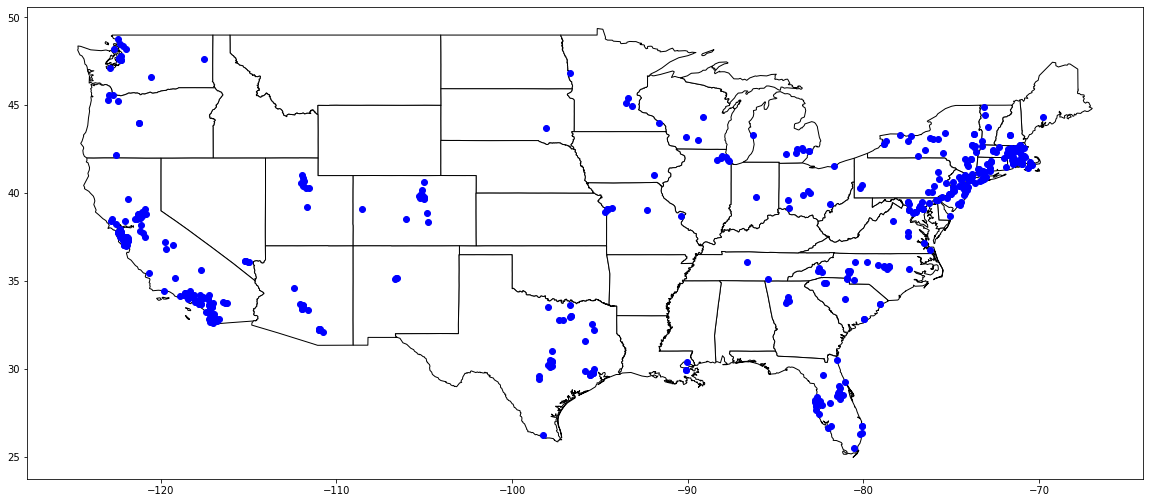

In [13]:
plot_coordinates_us(total_df[total_df['isES']==1])

### Example: a cluster routine 

get coordinates for clustering

In [14]:
es_coords=get_coords(total_df[total_df['isES']==1])



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Run the cluster and plot function

ready to cluster with radius= 30max_ep: 120 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


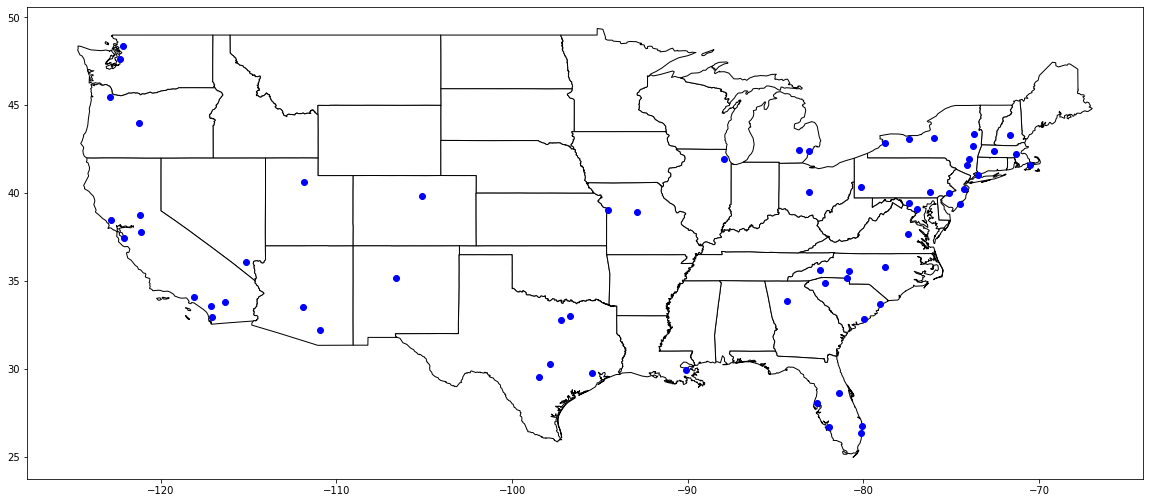

In [15]:
cluster_es=cluster_and_plot(30,120,2,es_coords)

In [16]:
cluster_es[2]

2

In [30]:
run_op=optics_coords_v2(30,120,min_size,es_coords)

ready to cluster with radius=30max_ep: 120 and min_size: 2 god speed


## Grid search 

### grid search space: 
- min_size: minimum number of points in a neighborhood to be considered a cluster : 2 to 10   
- min_eps: the epsilon distance used in cluster : range(10, 100, 5) from 10 to 100 with an increment of 5 
- max_eps: the maximum distance used in cluster : from min_eps+10 to min_eps+150 with an increment of 20 

### Perform Grid Search 

In [27]:
for i in range(2,3,1):
    print(i)

2


In [33]:
collect_result=[]
for min_size in range(2,3,1):
    for min_eps in range(140,180,1):
        for max_eps in range(min_eps+10,min_eps+110,100):
            run_op=optics_coords_v2(min_eps,max_eps,min_size,es_coords)
            sil_score=run_op[3]
            cal_score=run_op[4]
            num_cluster=run_op[5]
            print('sil score is .{}'.format(sil_score))
            print('cal score is .{}'.format(cal_score))
            print('number of cluster is .{}'.format(num_cluster))
            result=[min_size,min_eps,max_eps,sil_score,cal_score,num_cluster]
            collect_result=collect_result+result

ready to cluster with radius= 140max_ep: 150 and min_size: 2
sil score is .-0.4834299449731044
cal score is .691.6240102204026
number of cluster is .28
ready to cluster with radius= 141max_ep: 151 and min_size: 2
sil score is .-0.4834299449731044
cal score is .691.6240102204026
number of cluster is .28
ready to cluster with radius= 142max_ep: 152 and min_size: 2
sil score is .-0.4834299449731044
cal score is .691.6240102204026
number of cluster is .28
ready to cluster with radius= 143max_ep: 153 and min_size: 2
sil score is .-0.4845639269523994
cal score is .760.0944004321898
number of cluster is .28
ready to cluster with radius= 144max_ep: 154 and min_size: 2
sil score is .-0.4845639269523994
cal score is .760.0944004321898
number of cluster is .28
ready to cluster with radius= 145max_ep: 155 and min_size: 2
sil score is .-0.4832431027074063
cal score is .767.4219491993879
number of cluster is .28
ready to cluster with radius= 146max_ep: 156 and min_size: 2
sil score is .-0.4832431027

In [34]:
len(collect_result)

240

In [35]:
grid_search_df_4=pd.DataFrame(data=np.reshape(collect_result,(40,6)),columns=[['min_size','min_eps','max_eps','sil_score','cal_score','num_cluster']])

In [31]:
grid_search_df_3=pd.DataFrame(data=np.reshape(collect_result,(10,6)),columns=[['min_size','min_eps','max_eps','sil_score','cal_score','num_cluster']])

In [23]:
grid_search_df_2=pd.DataFrame(data=np.reshape(collect_result,(44,6)),columns=[['min_size','min_eps','max_eps','sil_score','cal_score','num_cluster']])

### More Gridsearch

In [17]:
collect_result=[]
for min_size in range(2,3,1):
    for min_eps in range(30,150,5):
        max_eps=min_eps+100 
        run_op=optics_coords_v2(min_eps,max_eps,min_size,es_coords)
        sil_score=run_op[3]
        cal_score=run_op[4]
        num_cluster=run_op[5]
        print('sil score is .{}'.format(sil_score))
        print('cal score is .{}'.format(cal_score))
        print('number of cluster is .{}'.format(num_cluster))
        result=[min_size,min_eps,max_eps,sil_score,cal_score,num_cluster]
        collect_result=collect_result+result

ready to cluster with radius= 30max_ep: 130 and min_size: 2
sil score is .-0.2170026042469437
cal score is .48.15357284843441
number of cluster is .63
ready to cluster with radius= 35max_ep: 135 and min_size: 2
sil score is .-0.2657848616069486
cal score is .66.66057471310666
number of cluster is .58
ready to cluster with radius= 40max_ep: 140 and min_size: 2
sil score is .-0.3149290519935652
cal score is .82.51767425384803
number of cluster is .56
ready to cluster with radius= 45max_ep: 145 and min_size: 2
sil score is .-0.3416617452468583
cal score is .111.12083390933974
number of cluster is .51
ready to cluster with radius= 50max_ep: 150 and min_size: 2
sil score is .-0.3452384099291254
cal score is .124.31254678011031
number of cluster is .51
ready to cluster with radius= 55max_ep: 155 and min_size: 2
sil score is .-0.40279915699329705
cal score is .165.12573444371517
number of cluster is .47
ready to cluster with radius= 60max_ep: 160 and min_size: 2
sil score is .-0.4476515386780

In [33]:
len(collect_result)

264

In [34]:
grid_search_df_2

,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
0,2.0,90.0,100.0,-0.487774,271.114749,37.0
1,2.0,90.0,150.0,-0.487774,271.114749,37.0
2,2.0,95.0,105.0,-0.484179,296.525655,36.0
3,2.0,95.0,155.0,-0.484179,296.525655,36.0
4,2.0,100.0,110.0,-0.483583,321.189247,35.0
5,2.0,100.0,160.0,-0.483583,321.189247,35.0
6,2.0,105.0,115.0,-0.479674,395.510863,34.0
7,2.0,105.0,165.0,-0.479674,395.510863,34.0
8,2.0,110.0,120.0,-0.476758,437.428332,33.0
9,2.0,110.0,170.0,-0.476758,437.428332,33.0


### Explore the results 

In [56]:
grid_search_df=pd.DataFrame(data=np.reshape(collect_result,(1008,6)),columns=[['min_size','min_eps','max_eps','sil_score','cal_score','num_cluster']])

In [58]:
grid_search_df.tail()

,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
1003,9.0,95.0,145.0,-0.426865,245.71354,11.0
1004,9.0,95.0,165.0,-0.426865,245.71354,11.0
1005,9.0,95.0,185.0,-0.426865,245.71354,11.0
1006,9.0,95.0,205.0,-0.426865,245.71354,11.0
1007,9.0,95.0,225.0,-0.426865,245.71354,11.0


### Export the grid search result 

In [26]:
grid_search_df_2.to_csv('optics_grid_search_'+version+'.csv')

In [27]:
grid_search_df_2.dropna().describe()

,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
count,44.0,44.000000,44.000000,44.000000,44.000000,44.000000
mean,2.0,142.500000,177.500000,-0.487039,698.391417,27.045455
std,0.0,32.088178,40.855673,0.008097,274.755008,6.393873
min,2.0,90.000000,100.000000,-0.503415,271.114749,16.000000
25%,2.0,115.000000,150.000000,-0.490463,461.610116,22.000000
50%,2.0,142.500000,177.500000,-0.484600,717.511415,28.000000
75%,2.0,170.000000,205.000000,-0.483243,933.458832,31.000000
max,2.0,195.000000,255.000000,-0.471389,1278.200977,37.000000


### Explore and plot the parameters in relation to cal_score

In [10]:
import pandas as pd 
grid_search_df=pd.read_csv('optics_grid_search_oct31.csv')
grid_search_df_2=pd.read_csv('optics_grid_search_dec_10.csv')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
grid_search_df.tail()

,Unnamed: 0,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
1003,1003,9.0,95.0,145.0,-0.426865,245.71354,11.0
1004,1004,9.0,95.0,165.0,-0.426865,245.71354,11.0
1005,1005,9.0,95.0,185.0,-0.426865,245.71354,11.0
1006,1006,9.0,95.0,205.0,-0.426865,245.71354,11.0
1007,1007,9.0,95.0,225.0,-0.426865,245.71354,11.0


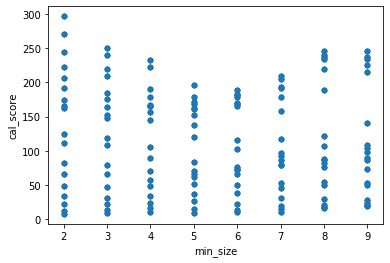

In [5]:
grid_search_df.plot(x ='min_size', y='cal_score', kind = 'scatter')


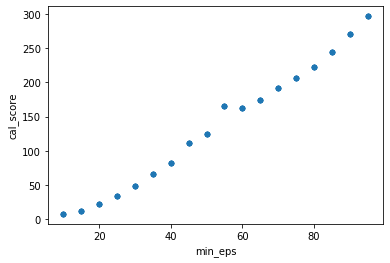

In [6]:
grid_search_df[grid_search_df['min_size']==2].plot(x ='min_eps', y='cal_score', kind = 'scatter')


In [11]:
grid_search_df_2.head()

,Unnamed: 0,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
0,0,2.0,90.0,100.0,-0.487774,271.114749,37.0
1,1,2.0,90.0,150.0,-0.487774,271.114749,37.0
2,2,2.0,95.0,105.0,-0.484179,296.525655,36.0
3,3,2.0,95.0,155.0,-0.484179,296.525655,36.0
4,4,2.0,100.0,110.0,-0.483583,321.189247,35.0


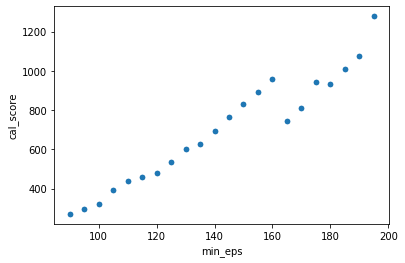

In [39]:
grid_search_df_2.plot(x ='min_eps', y='cal_score', kind = 'scatter')


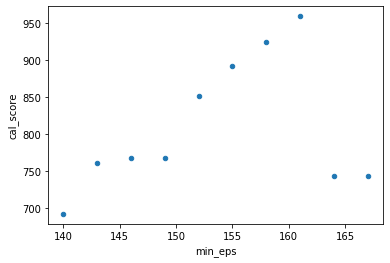

In [40]:
grid_search_df_3.plot(x ='min_eps', y='cal_score', kind = 'scatter')


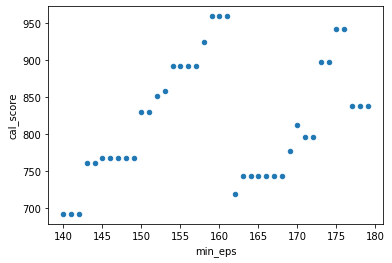

In [41]:
grid_search_df_4.plot(x ='min_eps', y='cal_score', kind = 'scatter')


In [51]:
grid_search_df_sum=pd.concat([grid_search_df_4,grid_search_df_3],axis=1)

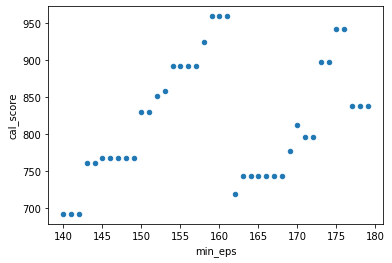

In [50]:
grid_search_df_4.plot(x ='min_eps', y='cal_score', kind = 'scatter')


In [58]:
grid_search_df_2=grid_search_df_2.drop(columns=['Unnamed: 0'])

In [88]:
grid_search_df_2.tail()

,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
39,2.0,185.0,245.0,-0.490463,1011.455236,17.0
40,2.0,190.0,200.0,-0.503099,1075.206947,16.0
41,2.0,190.0,250.0,-0.503099,1075.206947,16.0
42,2.0,195.0,205.0,-0.503415,1278.200977,16.0
43,2.0,195.0,255.0,-0.503415,1278.200977,16.0


In [89]:
grid_search_df_4.tail()

,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
35,2.0,175.0,185.0,-0.484580,941.212579,21.0
36,2.0,176.0,186.0,-0.484580,941.212579,21.0
37,2.0,177.0,187.0,-0.496872,837.853242,20.0
38,2.0,178.0,188.0,-0.496872,837.853242,20.0
39,2.0,179.0,189.0,-0.496872,837.853242,20.0


In [100]:
grid_search_df_4.to_csv('temp_4.csv')
grid_search_df_2.to_csv('temp_2.csv')
# after manually combine 


PermissionError: [Errno 13] Permission denied: 'temp_2.csv'

In [106]:
grid_search_df_4=pd.read_csv('temp_4.csv')

In [107]:
grid_search_df_4.describe()

,Unnamed: 0,min_size,min_eps,max_eps,sil_score,cal_score,num_cluster
count,84.000000,84.0,84.000000,84.000000,84.000000,84.000000,84.000000
mean,20.547619,2.0,150.595238,173.690476,-0.489334,755.335391,26.178571
std,12.276341,0.0,25.896048,30.742998,0.007828,213.937449,5.049539
min,0.000000,2.0,90.000000,100.000000,-0.503415,271.114749,16.000000
25%,10.000000,2.0,140.000000,156.750000,-0.496796,691.624010,23.000000
50%,20.500000,2.0,155.000000,171.500000,-0.486520,767.421949,27.000000
75%,31.000000,2.0,170.000000,186.250000,-0.483430,891.843094,28.000000
max,43.000000,2.0,195.000000,255.000000,-0.471389,1278.200977,37.000000


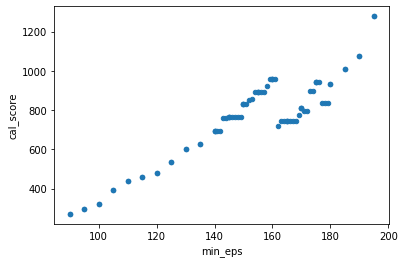

In [108]:
grid_search_df_4.plot(x ='min_eps', y='cal_score', kind = 'scatter')


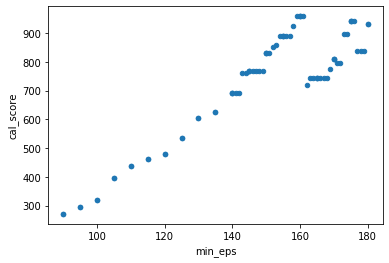

In [113]:
grid_search_df_4[grid_search_df_4['cal_score']<1000].plot(x ='min_eps', y='cal_score', kind = 'scatter')

No handles with labels found to put in legend.


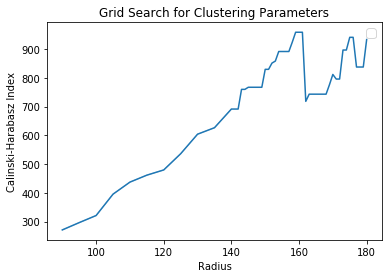

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns 
ax = sns.lineplot(x="min_eps", y="cal_score", data=grid_search_df_4[grid_search_df_4['cal_score']<1000],markers=True, dashes=False)
plt.legend(prop={'size':12})
plt.title('Grid Search for Clustering Parameters')
plt.xlabel('Radius')
plt.ylabel('Calinski-Harabasz Index')
plt.savefig('optics_parameter_gridsearch.png', dpi=400)

## Official Clustering: clustering with parameters with the highes cal score

In [17]:
es_coords

array([[  45.56908035, -122.94670105],
       [  42.50366974,  -83.78105927],
       [  34.00447845, -117.68470001],
       ...,
       [  42.6716156 ,  -73.24697876],
       [  42.37992477,  -72.60404205],
       [  42.36403275,  -72.45875549]])

ready to cluster with radius= 160max_ep: 220 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


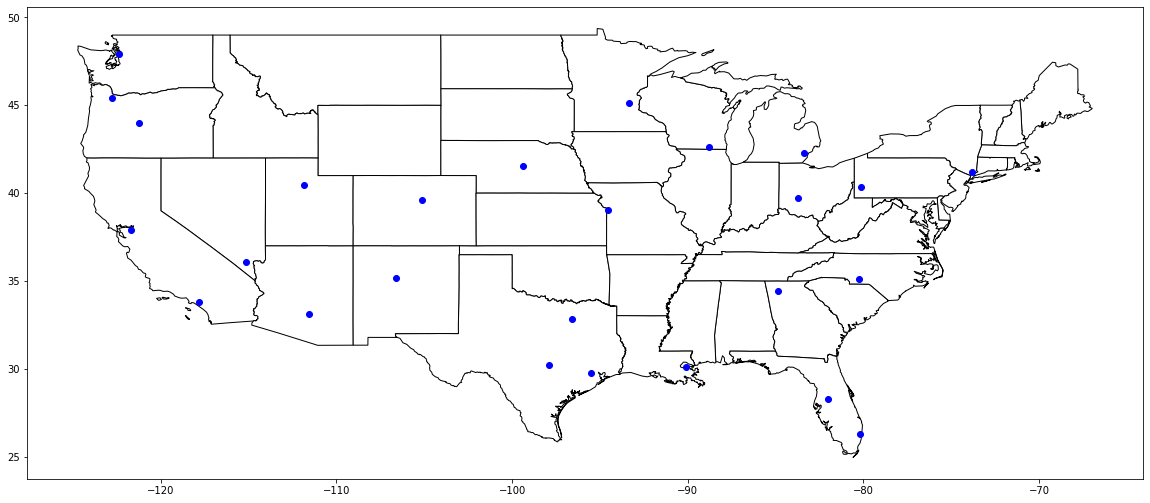

In [18]:
cluster_es=cluster_and_plot(160,220,2,es_coords)

## post-clustering diagnostics: produce the cluster diameter distance 

In [19]:
import pandas as pd
parameters='160_220_2'
es_labeled=pd.read_csv(r'../2_pipeline/es_labeled'+parameters+'.csv')

In [20]:
es_labeled.head()

,Unnamed: 0,labels,lat,long
0,0,0,45.569080,-122.946701
1,1,12,42.503670,-83.781059
2,2,4,34.004478,-117.684700
3,3,6,33.610741,-111.891472
4,4,22,29.985395,-95.346214


In [26]:
def get_distance_from_index(cluster,index_pair):
    la1,long1,la2,long2=cluster.iloc[index_pair[0]].lat,a_cluster.iloc[index_pair[0]].long,a_cluster.iloc[index_pair[1]].lat,a_cluster.iloc[index_pair[1]].long
    distance=haversine(la1,long1,la2,long2)
    return distance


In [27]:
a_cluster=es_labeled[es_labeled['labels']==2].drop_duplicates()
a_cluster

,Unnamed: 0,labels,lat,long
87,87,2,44.000626,-121.23381
88,88,2,44.000626,-121.23381


In [28]:
for label in set(es_labeled.labels): 
    a_cluster=es_labeled[es_labeled['labels']==label]
    print('the market {} has {} installers'.format(label,len(a_cluster)))

the market 0 has 4 installers
the market 1 has 12 installers
the market 2 has 2 installers
the market 3 has 55 installers
the market 4 has 82 installers
the market 5 has 5 installers
the market 6 has 16 installers
the market 7 has 10 installers
the market 8 has 12 installers
the market 9 has 3 installers
the market 10 has 3 installers
the market 11 has 10 installers
the market 12 has 8 installers
the market 13 has 2 installers
the market 14 has 7 installers
the market 15 has 183 installers
the market 16 has 25 installers
the market 17 has 6 installers
the market 18 has 5 installers
the market 19 has 28 installers
the market 20 has 5 installers
the market 21 has 10 installers
the market 22 has 10 installers
the market 23 has 12 installers
the market 24 has 3 installers
the market -1 has 12 installers


In [29]:
import itertools 
max_distance_list=[]
for label in set(es_labeled.labels):   
    a_cluster=es_labeled[es_labeled['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    print('the market {} has max distance  {}'.format(label,max_distance))
    max_distance_list=max_distance_list+[label,max_distance]
    

the market 0 has max distance  32.45760508909485
the market 1 has max distance  118.32042513276699
the market 2 has max distance  0.0
the market 3 has max distance  229.97806889506217
the market 4 has max distance  292.8774807282359
the market 5 has max distance  12.899509369502022
the market 6 has max distance  197.19695091320116
the market 7 has max distance  127.4088652678399
the market 8 has max distance  158.63778033788233
the market 9 has max distance  4.068235519679192
the market 10 has max distance  33.33672660099071
the market 11 has max distance  251.14026147782818
the market 12 has max distance  148.03889172902046
the market 13 has max distance  11.81559534894514
the market 14 has max distance  226.48740193780864
the market 15 has max distance  586.4045368111861
the market 16 has max distance  290.9300072615483
the market 17 has max distance  204.47199003043949
the market 18 has max distance  27.258650330812294
the market 19 has max distance  268.35719644133655
the market 20

### Plotting New England individually to diagnoze the problem ( max distance too large)

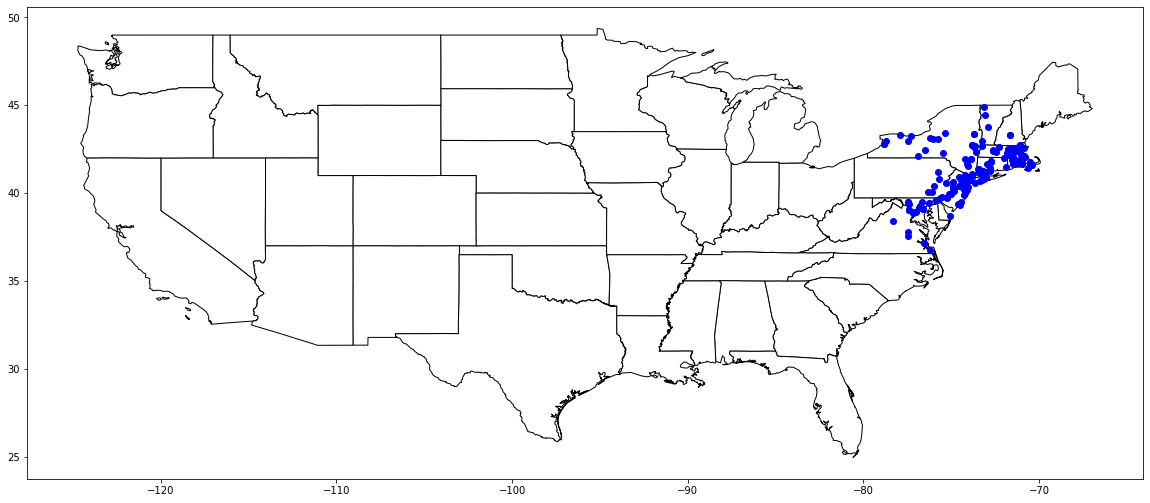

In [21]:
plot_coordinates_us(es_labeled[es_labeled['labels']==15].drop_duplicates())

In [22]:
es_coords_market_newengland=get_coords(es_labeled[es_labeled['labels']==15][['lat','long']].drop_duplicates())



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


ready to cluster with radius= 35max_ep: 50 and min_size: 6


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


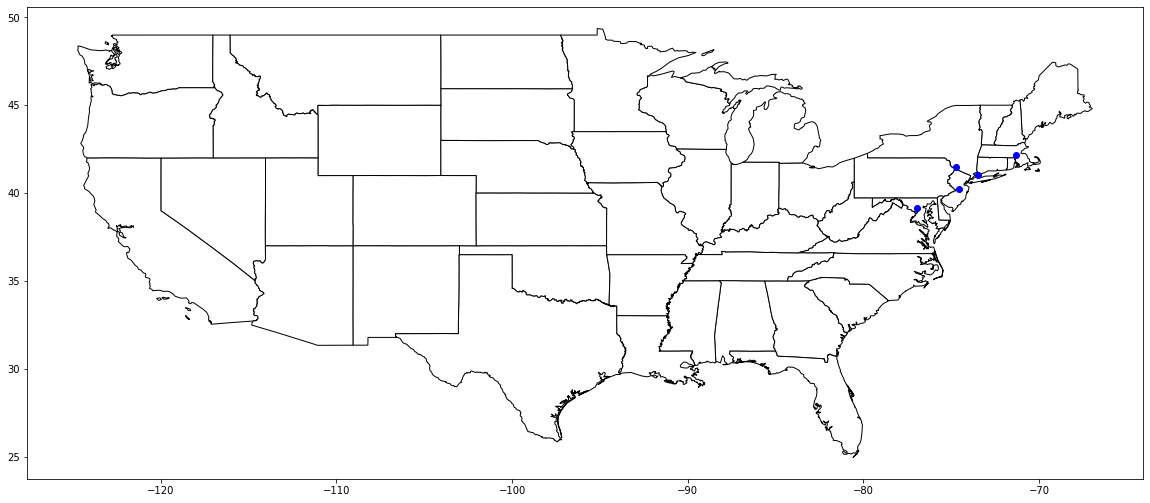

In [23]:
newengland_optics=cluster_and_plot(35,50,6,es_coords_market_newengland)

New England labeling 

In [24]:
es_labeled_newengland=pd.DataFrame(columns=['labels','lat','long'])
es_labeled_newengland['labels']=newengland_optics[0].labels_
es_labeled_newengland['lat']=es_coords_market_newengland[:,0]
es_labeled_newengland['long']=es_coords_market_newengland[:,1]
es_labeled_newengland.head()

,labels,lat,long
0,-1,37.759697,-77.481873
1,0,39.492413,-76.674446
2,2,40.889721,-73.941978
3,0,39.057537,-77.392006
4,-1,42.475479,-72.615402


### Examine the new cluster distances for just New England 

In [30]:
max_distance_list=[]
for label in set(es_labeled_newengland.labels):   
    a_cluster=es_labeled_newengland[es_labeled_newengland['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    print('the market {} has max distance  {}'.format(label,max_distance))
    max_distance_list=max_distance_list+[label,max_distance]
    

the market 0 has max distance  51.616468220702814
the market 1 has max distance  83.59776769475471
the market 2 has max distance  111.41118773166728
the market 3 has max distance  79.18166438702463
the market -1 has max distance  586.4045368111861


In [31]:
len(es_labeled_newengland[es_labeled_newengland['labels']==-1])

58

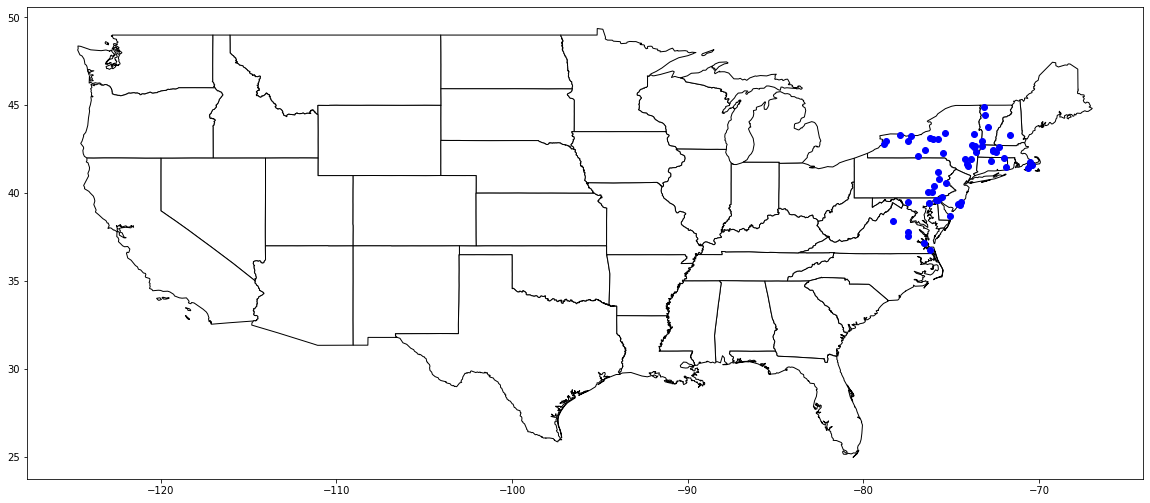

In [32]:
plot_coordinates_us(es_labeled_newengland[es_labeled_newengland['labels']==-1])

In [33]:
es_labeled_newengland[es_labeled_newengland['labels']==-1]

,labels,lat,long
0,-1,37.759697,-77.481873
4,-1,42.475479,-72.615402
5,-1,42.605438,-72.292076
6,-1,38.686005,-75.086678
7,-1,37.147812,-76.543037
8,-1,36.762287,-76.211647
9,-1,37.539768,-77.435532
10,-1,38.407593,-78.295296
12,-1,39.627144,-75.859894
14,-1,39.479137,-77.442986


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


ready to cluster with radius= 90max_ep: 150 and min_size: 8


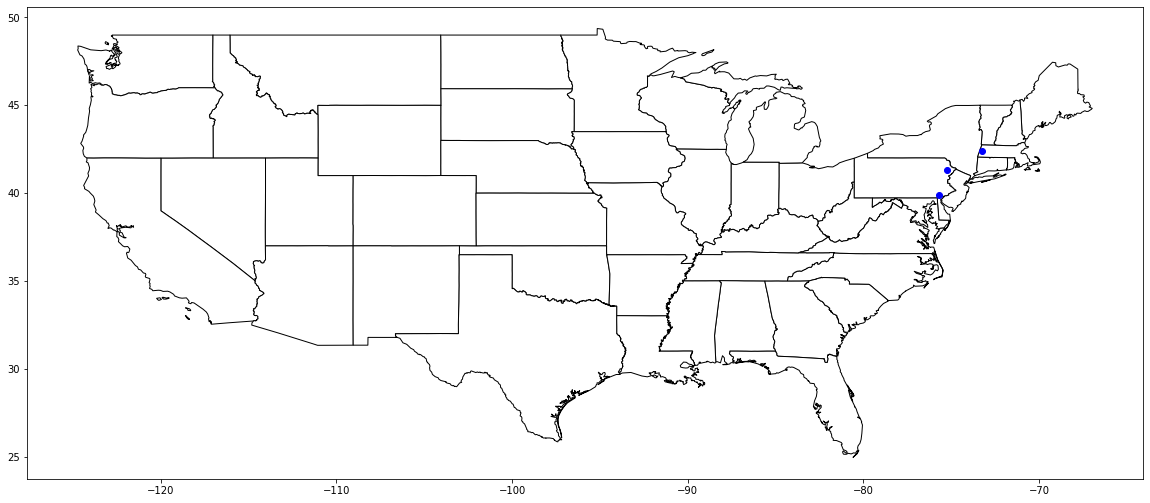

In [35]:
newengland_outcasts_coords=get_coords(es_labeled_newengland[es_labeled_newengland['labels']==-1])
newengland_outcasts=cluster_and_plot(90,150,8,newengland_outcasts_coords)

In [36]:
es_labeled_newengland_outcasts=pd.DataFrame(columns=['labels','lat','long'])
es_labeled_newengland_outcasts['labels']=newengland_outcasts[0].labels_
es_labeled_newengland_outcasts['lat']=newengland_outcasts_coords[:,0]
es_labeled_newengland_outcasts['long']=newengland_outcasts_coords[:,1]
es_labeled_newengland_outcasts.head()
max_distance_list=[]
for label in set(es_labeled_newengland_outcasts.labels):   
    a_cluster=es_labeled_newengland_outcasts[es_labeled_newengland_outcasts['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    print('the market {} has max distance  {}'.format(label,max_distance))
    max_distance_list=max_distance_list+[label,max_distance]
    

the market 0 has max distance  102.09910971128227
the market 1 has max distance  127.08609012276611
the market -1 has max distance  586.4045368111861


In [37]:
es_labeled_newengland_outcasts[es_labeled_newengland_outcasts['labels']==-1]

,labels,lat,long
0,-1,37.759697,-77.481873
3,-1,38.686005,-75.086678
4,-1,37.147812,-76.543037
5,-1,36.762287,-76.211647
6,-1,37.539768,-77.435532
7,-1,38.407593,-78.295296
8,-1,39.627144,-75.859894
9,-1,39.479137,-77.442986
10,-1,39.436626,-76.289757
14,-1,41.230492,-75.757439


## TODO figure out the two step data labels merging

### merge es_labeled with 2nd step clustering es_labeled_newengland
###  remap es_labeled_newengland labels

In [38]:
di_neweng_label = {0:33, 1:34 ,2:35 ,3:36,-1:17}
es_labeled_newengland_copy=es_labeled_newengland
es_labeled_newengland_copy=es_labeled_newengland_copy.replace({"labels": di_neweng_label}) 

### Try new parameters as well drop duplicates 

## More Grid Search on deduplicated coords 

In [46]:
collect_result=[]
for min_size in range(2,3,1):
    for min_eps in range(30,150,5):
        max_eps=min_eps+100 
        run_op=optics_coords_v2(min_eps,max_eps,min_size,es_coords)
        sil_score=run_op[3]
        cal_score=run_op[4]
        num_cluster=run_op[5]
        print('sil score is .{}'.format(sil_score))
        print('cal score is .{}'.format(cal_score))
        print('number of cluster is .{}'.format(num_cluster))
        result=[min_size,min_eps,max_eps,sil_score,cal_score,num_cluster]
        collect_result=collect_result+result

ready to cluster with radius= 30max_ep: 130 and min_size: 2
sil score is .-0.2170026042469437
cal score is .48.15357284843441
number of cluster is .63
ready to cluster with radius= 35max_ep: 135 and min_size: 2
sil score is .-0.2657848616069486
cal score is .66.66057471310666
number of cluster is .58
ready to cluster with radius= 40max_ep: 140 and min_size: 2
sil score is .-0.3149290519935652
cal score is .82.51767425384803
number of cluster is .56
ready to cluster with radius= 45max_ep: 145 and min_size: 2
sil score is .-0.3416617452468583
cal score is .111.12083390933974
number of cluster is .51
ready to cluster with radius= 50max_ep: 150 and min_size: 2
sil score is .-0.3452384099291254
cal score is .124.31254678011031
number of cluster is .51
ready to cluster with radius= 55max_ep: 155 and min_size: 2
sil score is .-0.40279915699329705
cal score is .165.12573444371517
number of cluster is .47
ready to cluster with radius= 60max_ep: 160 and min_size: 2
sil score is .-0.4476515386780

### try the min_eps = 145 



ready to cluster with radius= 90max_ep: 245 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


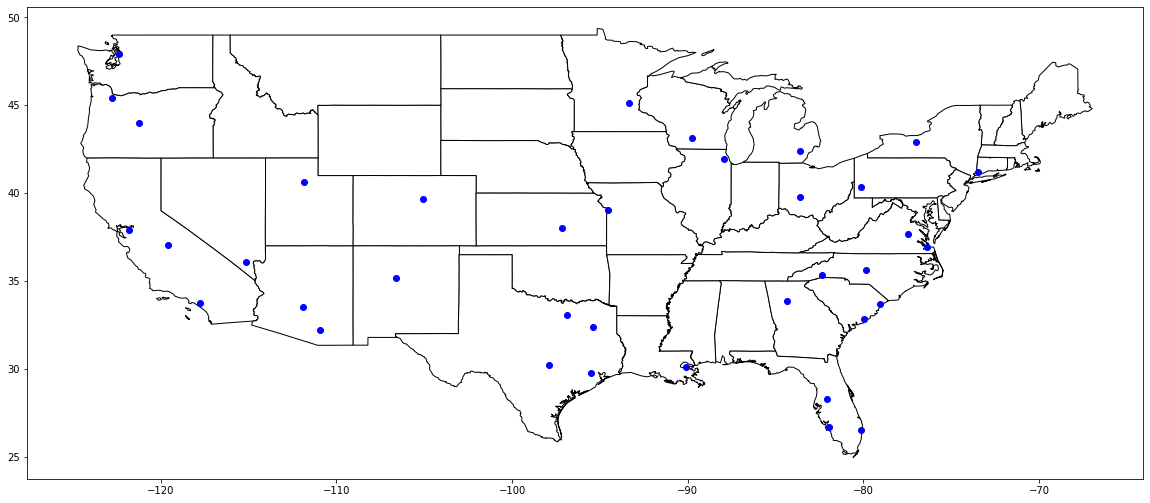

In [39]:
run_op=cluster_and_plot(90,245,2,es_coords)

In [44]:
es_labeled=pd.DataFrame(columns=['labels','lat','long'])
es_labeled['labels']=run_op[0].labels_
es_labeled['lat']=es_coords[:,0]
es_labeled['long']=es_coords[:,1]
es_labeled.head()

,labels,lat,long
0,0,45.569080,-122.946701
1,15,42.503670,-83.781059
2,5,34.004478,-117.684700
3,7,33.610741,-111.891472
4,33,29.985395,-95.346214


In [45]:
max_distance_list=[]
for label in set(es_labeled.labels):   
    a_cluster=es_labeled[es_labeled['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    print('the market {} has max distance  {}'.format(label,max_distance))
    max_distance_list=max_distance_list+[label,max_distance]
    

the market 0 has max distance  32.45760508909485
the market 1 has max distance  118.32042513276699


IndexError: list index out of range

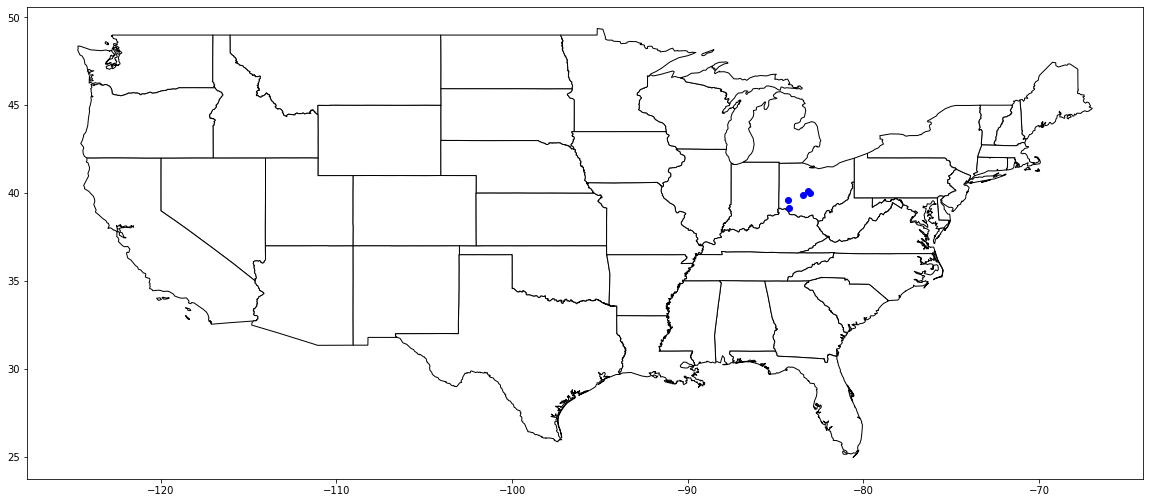

In [42]:
plot_coordinates_us(es_labeled[es_labeled['labels']==17])

## Tidy up and export the clustering result to 2_pipelinefolder


In [26]:
es_labeled=pd.DataFrame(columns=['labels','lat','long'])
es_labeled['labels']=cluster_es[0].labels_
es_labeled['lat']=es_coords[:,0]
es_labeled['long']=es_coords[:,1]
es_labeled.head()

,labels,lat,long
0,0,45.569080,-122.946701
1,12,42.503670,-83.781059
2,4,34.004478,-117.684700
3,6,33.610741,-111.891472
4,22,29.985395,-95.346214


In [37]:
pwd

'C:\\Users\\Herbie Huang\\Google Drive\\Current_SolarResearch\\working_june2020\\solar_project\\1_code'

###  NOTE: pay attention to the two different version - twostep version means the new england data are re-clustered 

In [38]:
parameters='160_220_2'
es_labeled.to_csv(r'../2_pipeline/es_labeled'+parameters+'.csv')

In [ ]:
es_labeled=es_labeled.drop(columns=['Unnamed: 0'])
es_labeled_new=pd.concat([es_labeled[es_labeled['labels']!=17],es_labeled_newengland_copy])
es_labeled_new.describe()
es_labeled_new.to_csv(r'../2_pipeline/es_labeled'+parameters+'two_step'+'.csv')

# More plotting 

In [47]:
es_labeled=pd.read_csv('../2_pipeline/es_labeled90_100_2two_step.csv')

In [48]:
es_labeled.head()

,Unnamed: 0,labels,lat,long
0,0,0,45.569080,-122.946701
1,1,14,42.503670,-83.781059
2,2,4,34.004478,-117.684700
3,3,6,33.610741,-111.891472
4,4,30,29.985395,-95.346214


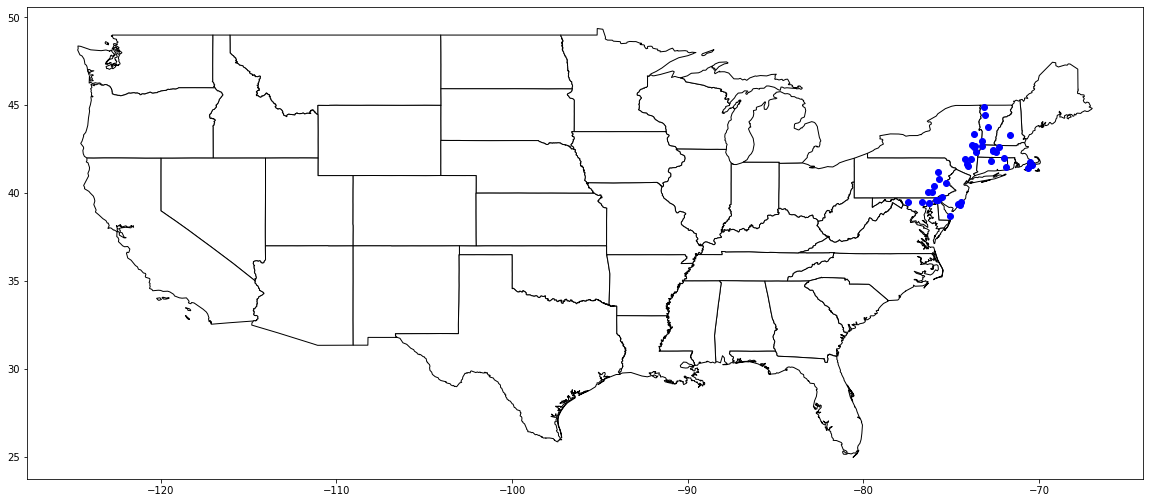

In [49]:
plot_coordinates_us(es_labeled[es_labeled['labels']==17])

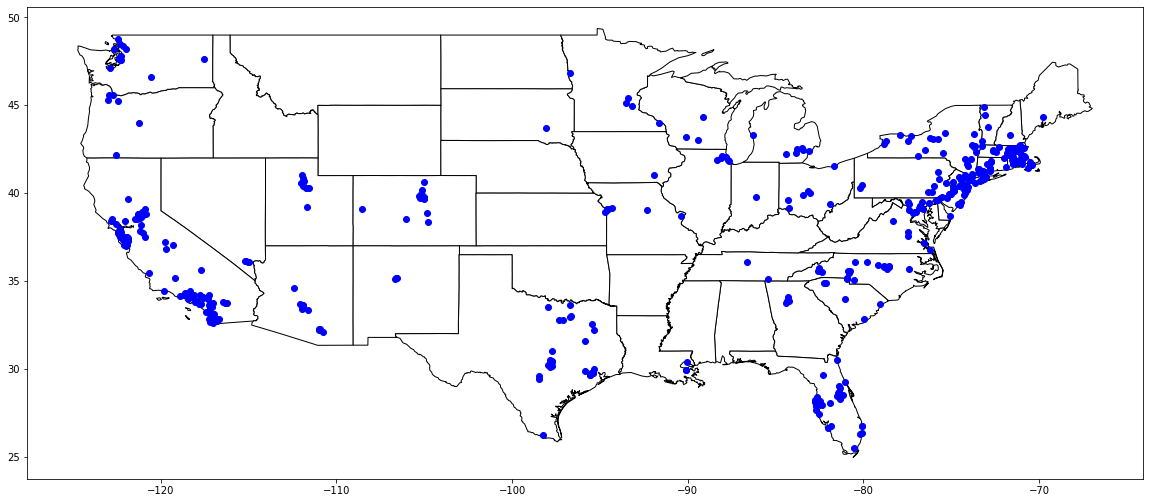

In [50]:
plot_coordinates_us(es_labeled)

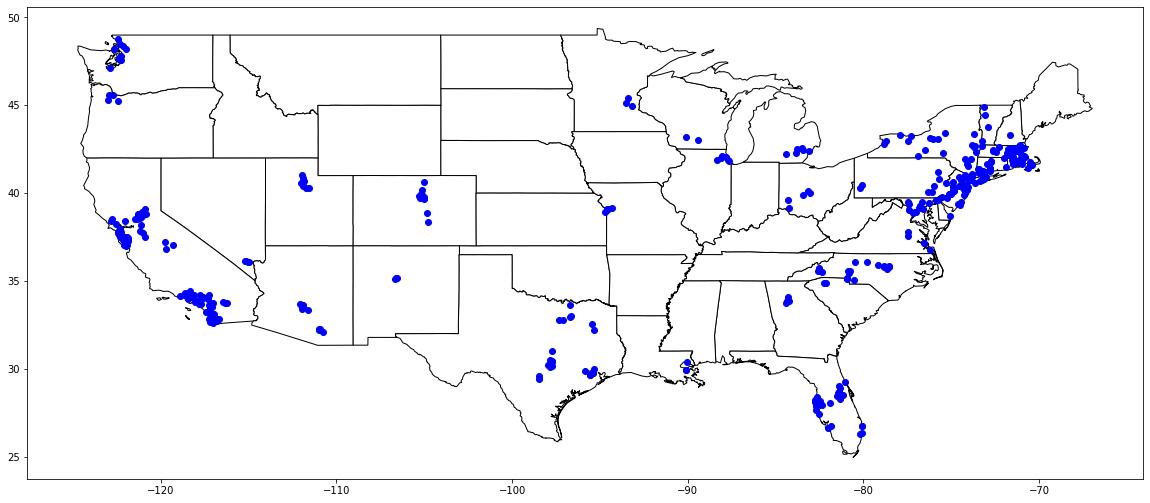

In [53]:
plot_coordinates_us(es_labeled[es_labeled['labels']!=-1])

In [55]:
es_labeled_jitter=es_labeled.copy(deep=True)

In [56]:
es_labeled_jitter.head()

,Unnamed: 0,labels,lat,long
0,0,0,45.569080,-122.946701
1,1,14,42.503670,-83.781059
2,2,4,34.004478,-117.684700
3,3,6,33.610741,-111.891472
4,4,30,29.985395,-95.346214


In [64]:
import random
print(random.uniform(0,0.5))

0.28035648098977034


In [65]:
len(es_labeled_jitter)

463

In [72]:
np.random.uniform(0,0.5,len(es_labeled_jitter))

array([3.46342547e-02, 2.08088038e-01, 3.49221710e-01, 1.95742045e-01,
       2.44945490e-01, 3.18682407e-01, 2.92461170e-01, 1.55633041e-03,
       1.76594249e-01, 1.87360987e-01, 4.91282251e-01, 2.22233574e-01,
       1.50027139e-01, 4.40482785e-01, 3.17702908e-01, 5.39456713e-02,
       2.72908280e-01, 4.10561001e-01, 1.59992680e-02, 3.54061178e-01,
       5.47882767e-02, 4.62894580e-01, 1.93183422e-01, 8.96470406e-03,
       4.25441637e-01, 2.51227847e-01, 1.40733745e-01, 3.60598380e-02,
       1.66785840e-01, 1.11952981e-01, 3.62198733e-01, 1.15730787e-01,
       2.44054056e-01, 1.30627896e-01, 2.35203451e-01, 9.17525909e-03,
       2.57556881e-01, 4.33171109e-01, 3.06153627e-01, 1.53846301e-01,
       2.22130721e-01, 4.72235844e-01, 1.76104601e-01, 2.41044031e-01,
       2.57499435e-01, 4.95256882e-01, 2.93898988e-01, 3.74324925e-01,
       4.23913408e-01, 2.92008049e-01, 3.82498505e-01, 4.10267863e-01,
       5.22338447e-02, 2.17868167e-01, 3.56027328e-01, 2.95642271e-01,
      

In [77]:
es_labeled_jitter['jitter_lat']=np.random.uniform(-0.5,0.5,len(es_labeled_jitter))

In [74]:
es_labeled_jitter.head()

,Unnamed: 0,labels,lat,long,jitter_lat
0,0,0,45.569080,-122.946701,0.106542
1,1,14,42.503670,-83.781059,0.202942
2,2,4,34.004478,-117.684700,0.374248
3,3,6,33.610741,-111.891472,0.460191
4,4,30,29.985395,-95.346214,0.060574


In [78]:
es_labeled_jitter['jitter_long']=np.random.uniform(-0.5,0.5,len(es_labeled_jitter))

In [79]:
es_labeled_jitter.head()

,Unnamed: 0,labels,lat,long,jitter_lat,jitter_long
0,0,0,45.569080,-122.946701,0.367964,0.433414
1,1,14,42.503670,-83.781059,-0.214203,0.389986
2,2,4,34.004478,-117.684700,0.359657,0.362290
3,3,6,33.610741,-111.891472,-0.173094,0.406873
4,4,30,29.985395,-95.346214,0.422454,-0.067683


In [80]:
es_labeled_jitter['lat']=es_labeled_jitter['lat']+es_labeled_jitter['jitter_lat']

In [82]:
es_labeled_jitter['long']=es_labeled_jitter['long']+es_labeled_jitter['jitter_long']

In [83]:
es_labeled_jitter.head()

,Unnamed: 0,labels,lat,long,jitter_lat,jitter_long
0,0,0,45.937045,-122.513287,0.367964,0.433414
1,1,14,42.289466,-83.391073,-0.214203,0.389986
2,2,4,34.364136,-117.322410,0.359657,0.362290
3,3,6,33.437646,-111.484599,-0.173094,0.406873
4,4,30,30.407849,-95.413897,0.422454,-0.067683


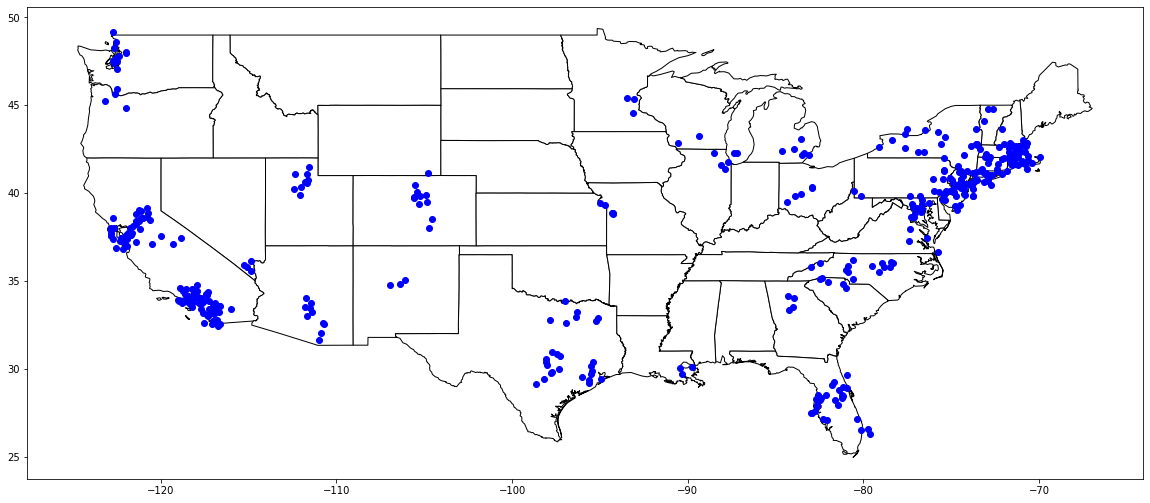

In [84]:
plot_coordinates_us(es_labeled_jitter[es_labeled_jitter['labels']!=-1])

## A plot that plot both installers and clusters

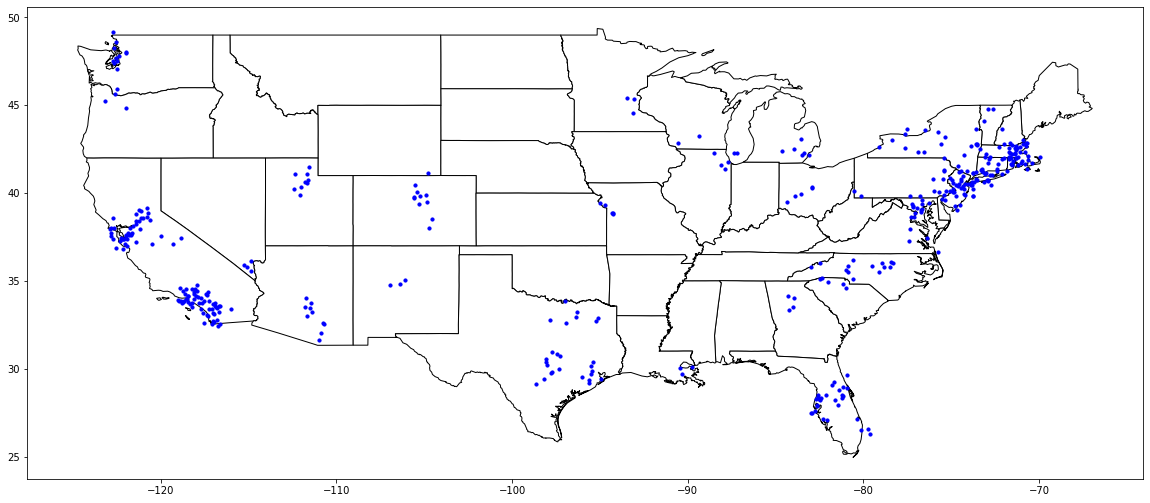

In [125]:

coords=  es_labeled_jitter[es_labeled_jitter['labels']!=-1]
mapurl='../0_data/rawdata_geospatial/states_21basic/states.shp'
usa=gpd.read_file(mapurl)
    
coords_df=pd.DataFrame()
coords_df['Coordinates']=tuple(zip(coords['long'],coords['lat']))
coords_df['Coordinates']=coords_df
coords_df['Coordinates']=coords_df['Coordinates'].apply(Point)
# put into a geopandas dataframe 
gdf=gpd.GeoDataFrame(coords_df,geometry='Coordinates')
ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='blue',marker='o',markersize=10, alpha=1)

plt.savefig('../2_pipeline/installer_jitter.png')
plt.show()   

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


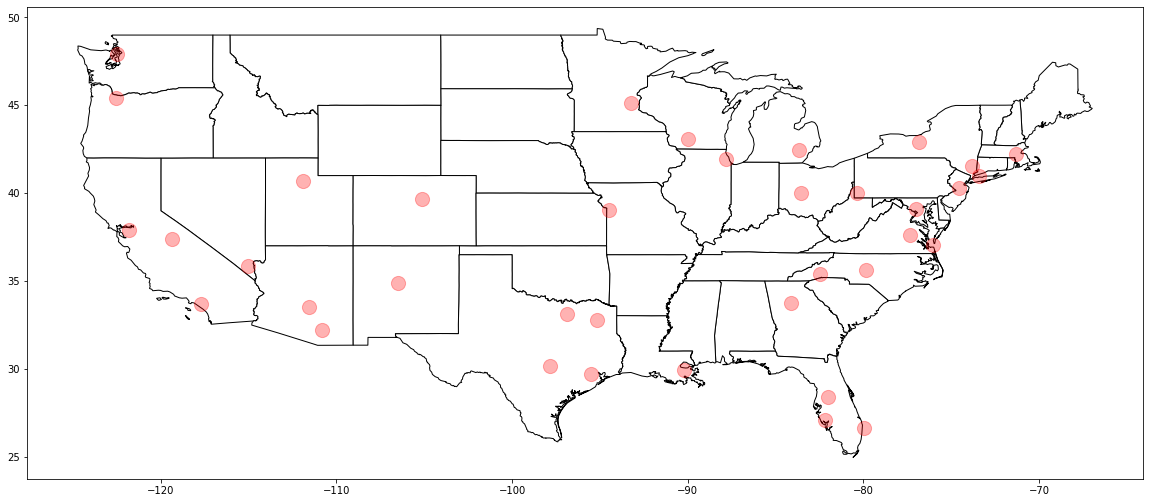

In [126]:
#find centroid for plotting 
total_cluster_ct=[]
for label in set(es_labeled_jitter.labels):
    if label!=-1:
        temp_centroid=get_centroid(get_coords(es_labeled_jitter[es_labeled_jitter['labels']==label]))
        total_cluster_ct=total_cluster_ct+[temp_centroid]

cluster_centroids=pd.DataFrame()
cluster_centroids['Coordinates']=total_cluster_ct
cluster_centroids['Coordinates']=cluster_centroids['Coordinates'].apply(Point)
# put into a geopandas dataframe 
mapurl='C:/Users/herbie huang/Google Drive/Current_SolarResearch/rawdata_geospatial/states_21basic/states.shp'
usa=gpd.read_file(mapurl)

gdf_centroid=gpd.GeoDataFrame(cluster_centroids,geometry='Coordinates')
ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

gdf_centroid.plot(ax=ax, color='red',marker='o',markersize=200,alpha=0.3)
plt.savefig('../2_pipeline/clusters_mkt.png')
plt.show()

## Combined 

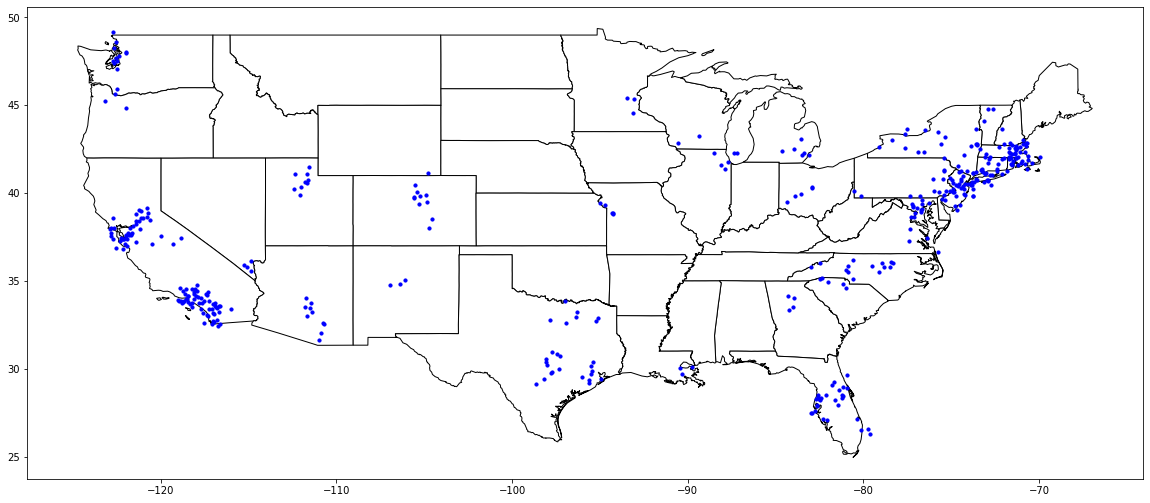

In [127]:
coords=  es_labeled_jitter[es_labeled_jitter['labels']!=-1]
mapurl='../0_data/rawdata_geospatial/states_21basic/states.shp'
usa=gpd.read_file(mapurl)
    
coords_df=pd.DataFrame()
coords_df['Coordinates']=tuple(zip(coords['long'],coords['lat']))
coords_df['Coordinates']=coords_df
coords_df['Coordinates']=coords_df['Coordinates'].apply(Point)
 
gdf_installers=gpd.GeoDataFrame(coords_df,geometry='Coordinates')
ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
gdf_installers.plot(ax=ax, color='blue',marker='o',markersize=10, alpha=1) 
plt.show()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


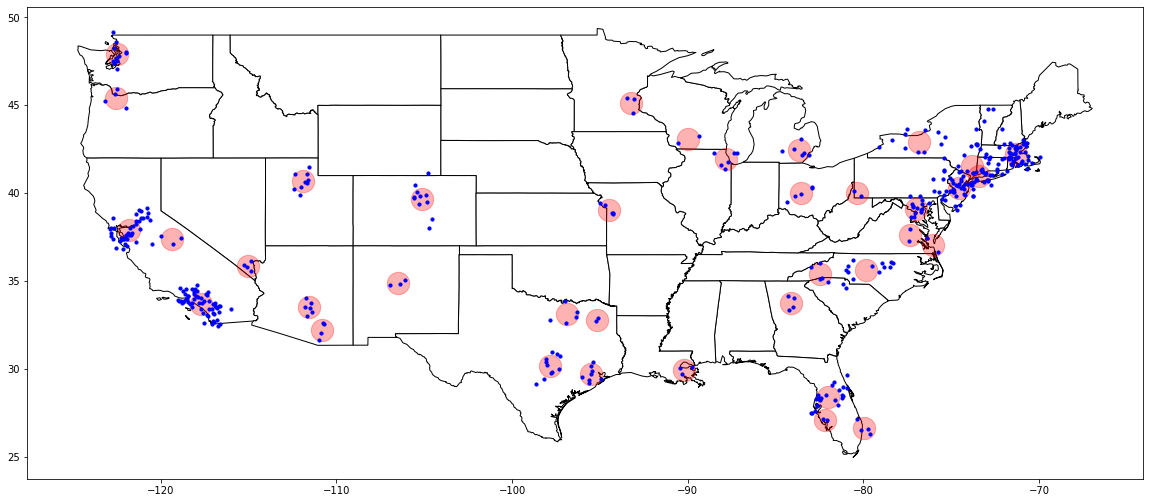

In [128]:
total_cluster_ct=[]

for label in set(es_labeled_jitter.labels):
        #print(label)
    if label!=-1:
        temp_centroid=get_centroid(get_coords(es_labeled_jitter[es_labeled_jitter['labels']==label]))
        total_cluster_ct=total_cluster_ct+[temp_centroid]

cluster_centroids=pd.DataFrame()
cluster_centroids['Coordinates']=total_cluster_ct
cluster_centroids['Coordinates']=cluster_centroids['Coordinates'].apply(Point)
 
gdf_centroid=gpd.GeoDataFrame(cluster_centroids,geometry='Coordinates')
 

gdf=gpd.GeoDataFrame(coords_df,geometry='Coordinates')
ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
gdf_centroid.plot(ax=ax, color='red',marker='o',markersize=500,alpha=0.3)
gdf_installers.plot(ax=ax, color='blue',marker='o',markersize=10, alpha=1) 

plt.savefig('../2_pipeline/installer_jitter_cluster_overlay.png')

plt.show()
    